In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# グラフ描画
from matplotlib import pylab as plt

# グラフを横長にする
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [2]:
import tensorflow as tf

In [3]:
df_m1 = pd.read_csv('USD_JPY_M1_20210120_20210204.csv')

In [4]:
def make_dataset(df, window_size, variable_cols = ['O', 'H', 'L', 'C'], target_col='C'):

    num_var = len(variable_cols)
    data, target = [], []

    for i in range(len(df) - window_size):
        data.append(df[variable_cols][i:i + window_size])
        target.append(df[target_col].iloc[i + window_size])

    re_data = np.array(data).reshape(len(data), window_size, num_var)
    re_target = np.array(target).reshape(len(data), 1)

    return re_data, re_target

In [5]:
def standard(se):
    
    mean =  se.values.mean()
    std =  se.values.std()
    adj = (se.values - mean) / std
    
    return mean, std, adj

In [6]:
mean_open, std_open, df_m1['O_st'] = standard(df_m1['O'] )
mean_high, std_high, df_m1['H_st'] = standard(df_m1['H'] )
mean_low, std_low, df_m1['L_st'] = standard(df_m1['L'] )
mean_close, std_close, df_m1['C_st'] = standard(df_m1['C'] )

In [7]:
window = 80
data_length = 15000
x, y = make_dataset(df_m1[-data_length:], window, variable_cols = ['O_st', 'H_st', 'L_st', 'C_st'], target_col='C_st')

In [8]:
val_size = 300
test_size = 100

x_train =  x[:-test_size][:-val_size]
x_val =  x[:-test_size][-val_size:]
x_test = x[-test_size:]

y_train =  y[:-test_size][:-val_size]
y_val =  y[:-test_size][-val_size:]
y_test = y[-test_size:]

In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(500, activation='relu', input_shape=(None, 4)),
    tf.keras.layers.Dense(30),
    tf.keras.layers.Dense(1)
])
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.MeanSquaredError())

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 500)               1010000   
_________________________________________________________________
dense (Dense)                (None, 30)                15030     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 1,025,061
Trainable params: 1,025,061
Non-trainable params: 0
_________________________________________________________________


In [11]:
batch_size = 100
n_epoch = 100

# 学習
hist = model.fit(x_train, y_train,
                 epochs=n_epoch,
                 validation_data=(x_val, y_val),
                 verbose=1,
                 batch_size=batch_size)

Epoch 1/100
146/146 [==============================] - 33s 223ms/step - loss: 0.0352 - val_loss: 0.0018
Epoch 2/100
146/146 [==============================] - 33s 226ms/step - loss: 2.7978e-04 - val_loss: 0.0016
Epoch 3/100
146/146 [==============================] - 33s 226ms/step - loss: 2.4107e-04 - val_loss: 0.0026
Epoch 4/100
146/146 [==============================] - 33s 227ms/step - loss: 2.4810e-04 - val_loss: 0.0016
Epoch 5/100
146/146 [==============================] - 33s 226ms/step - loss: 2.5129e-04 - val_loss: 0.0014
Epoch 6/100
146/146 [==============================] - 33s 226ms/step - loss: 2.3780e-04 - val_loss: 0.0014
Epoch 7/100
146/146 [==============================] - 33s 226ms/step - loss: 2.2119e-04 - val_loss: 0.0014
Epoch 8/100
146/146 [==============================] - 33s 227ms/step - loss: 2.0992e-04 - val_loss: 0.0021
Epoch 9/100
146/146 [==============================] - 33s 227ms/step - loss: 2.2824e-04 - val_loss: 0.0020
Epoch 10/100
146/146 [==========

KeyboardInterrupt: 

In [12]:
plt.plot(hist.history['loss'],label="train set")
plt.plot(hist.history['val_loss'],label="val set")
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.ylim(0, 0.01)
plt.legend()
plt.show()

NameError: name 'hist' is not defined

In [13]:
# y_pred = model.predict(x_test)
# y_stack = np.vstack([y_train, y_val, y_pred])
y_stack  = model.predict(x)
y_stack = std_close * y_stack + mean_close

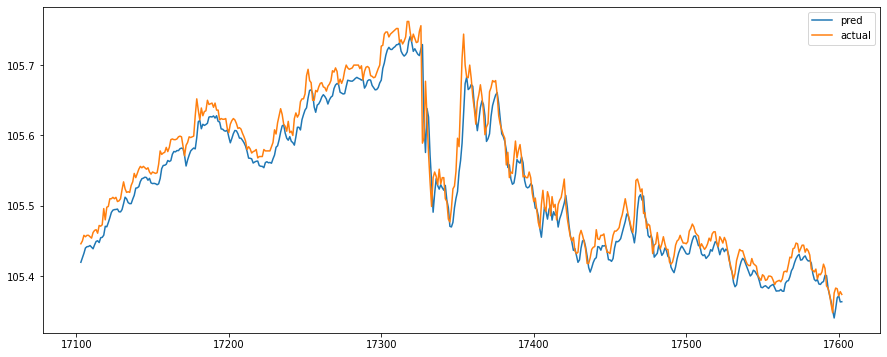

In [14]:
pd.Series(y_stack[:, 0], index=df_m1[-data_length+window:].index)[-500:].plot(label='pred')
df_m1[-data_length+window:]['C'][-500:].plot(label='actual')
plt.legend()
plt.show()